# Compute the displacement pulse from the P wave velocity waveform

We convert the P wave velocity pulse to the displacement pulse to evaluate the source parameters.

2024.11.18 Kurama Okubo

- NOTE: We originally evaluated the half-maximum-pulse-width to evaluate the source parameters. However, it was unstable when the pulse shape was perturbed, and it was difficult to make a criteria to qualify the source time function. We thus switched to use the synthetic source time function fitting

- 2024.11.19 update computing LBA for the case without correction of attenuation factor to fit the STF.

- 2024.11.21 update applying the low-pass filter before Q deconvolution. Update detrending; we remove the constant offset to keep the flat trace before the P arrival.

- 2024.11.25 update making an option to denoise with the detrend or the high-pass two-way filter.

- 2024.11.28 update detrend parameters for the low S/N events.

In [1]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
%load_ext autoreload
%autoreload 2
import glob
from glob import glob
import numpy as np
import mpmath as mp
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings

from matplotlib import gridspec

from scipy import interpolate
from scipy.optimize import curve_fit  
import matplotlib as mpl
import pickle
import copy

import seaborn as sns 
from scipy.interpolate import LSQUnivariateSpline
from scipy import integrate
from scipy.interpolate import CubicSpline

import h5py # store the STF in hdf5

from detrend_func import *

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True
plt.rcParams['axes.linewidth'] = 0.75

from obspy.core.utcdatetime import UTCDateTime  
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion
UTCDateTime.DEFAULT_PRECISION = 8

In [2]:
dataoutdir = "../data/03_computePdisp"
if not os.path.exists(dataoutdir):
    os.makedirs(dataoutdir)

In [3]:
figdir = "../figure/debug_03_computePdisp/"
if not os.path.exists(figdir):
    os.makedirs(figdir)

# Data Preparation

1. Far-field displacement pulse
> Processed in `02_trim_Pwave_window.ipynb`. The data is dumped as `data/02_trim_pwave/st_repeat_Pdisp_OL08.pickle`.

2. Attenuation factor model
> Computed at `09_compute_Qinv.ipynb` using the ball-drop impact. This is used as the model of attenuation factor to correct from the observed displacement pulse.

# Process flow

1. Read velocity pulse
2. Process the pulse to compute the displacement and the source time function
3. Deconvolve the attenuation factor (constant Q & frequency-dependent Q)
4. Store the data

## Read the data of P wave pulses

In [4]:
# read trace
gougepatch_id = "G3" # to set output filename
Qinv_quart = 50

st_repeat_Pvel = read(f"../data/02_trim_pwave/st_repeat_Pvel_{gougepatch_id}_OL*.pickle", format="PICKLE")
st_repeat_Pdisp = read(f"../data/02_trim_pwave/st_repeat_Pdisp_{gougepatch_id}_OL*.pickle", format="PICKLE")

In [5]:
# selected AE sensors for patch G3
AEsensor_list = ["OL23", "OL07", "OL08", "OL22"] # update: we use 4 close sensors "OL24"] 

## Read attenuation factor

In [6]:
# read Q model
df_Qinv_quantile = pd.read_csv("../../Others/compute_attenuation_BD/data/df_Qinv_quantile.csv", index_col=0)
df_Qinv_quantile.head()

,freq,Qinv_25,Qinv_50,Qinv_75
0,0.039062,0.011021,0.033190,0.047364
1,0.078125,0.009510,0.018644,0.036034
2,0.117188,0.007150,0.016177,0.023803
3,0.156250,0.004902,0.010908,0.017652
4,0.195312,0.004246,0.008805,0.014766


## Load best-fit source parameters
Loading the source parameters estimated by the waveform fitting.

In [7]:
# Path to the best fit source parameters
bestfitsourceparam_finame = f"../../SourceInvFit/data/datacsv/gridsearch_bestparam_M0andTR_fb03-087.csv"

df_bestparam = pd.read_csv(bestfitsourceparam_finame, index_col=0) # from waveform inversion
datacases = df_bestparam.index
df_bestparam.head()

,VR_P_best,M0_best,TR_best,rake_best
fb03-087__0004,0.89,0.57,3.3,0
fb03-087__0009,0.73,0.05,3.1,0
fb03-087__0018,0.87,0.61,3.5,0
fb03-087__0019,0.79,0.05,3.1,0
fb03-087__0020,0.89,0.77,3.3,0


## Read radiation pattern coefficient

In [8]:
trimP_coef_columns = ["rdist", "incidentangle", "dip", "azimuth", "k_M0uz", "TR", "beta_coef_p"]
df_trimP_coef = pd.DataFrame(columns=trimP_coef_columns)

for stnm in AEsensor_list:
    df_trimP_sensor = pd.read_csv(f"../data/02_trim_pwave/trimP_coefficients_{gougepatch_id}_{stnm}.csv", index_col=0)

    if not df_trimP_coef.empty:
        df_trimP_coef = pd.concat([df_trimP_coef, df_trimP_sensor])
        
    else:
        df_trimP_coef = df_trimP_sensor
    

In [9]:
datacases = np.unique(df_trimP_coef.index)
datacases

array(['fb03-087__0004', 'fb03-087__0009', 'fb03-087__0018',
       'fb03-087__0019', 'fb03-087__0020', 'fb03-087__0021',
       'fb03-087__0024', 'fb03-087__0027', 'fb03-087__0030',
       'fb03-087__0031', 'fb03-087__0037', 'fb03-087__0038',
       'fb03-087__0040', 'fb03-087__0043', 'fb03-087__0044',
       'fb03-087__0049', 'fb03-087__0050', 'fb03-087__0052',
       'fb03-087__0055', 'fb03-087__0059', 'fb03-087__0061',
       'fb03-087__0062', 'fb03-087__0069', 'fb03-087__0072',
       'fb03-087__0075', 'fb03-087__0076', 'fb03-087__0077',
       'fb03-087__0081', 'fb03-087__0085', 'fb03-087__0088',
       'fb03-087__0089', 'fb03-087__0095', 'fb03-087__0099',
       'fb03-087__0100', 'fb03-087__0102', 'fb03-087__0109',
       'fb03-087__0110', 'fb03-087__0111', 'fb03-087__0118',
       'fb03-087__0120', 'fb03-087__0126', 'fb03-087__0128',
       'fb03-087__0129', 'fb03-087__0131'], dtype=object)

In [10]:
pd.options.display.float_format = '{:12.6g}'.format
df_trimP_coef.loc[datacases[13]]

,rdist,incidentangle,dip,azimuth,k_M0uz,TR,beta_coef_p,OL
datacase,,,,,,,,
fb03-087__0043,0.0955984,55.4255,42.9264,-56.432,1.40444e+15,3.2e-06,0.694268,OL23
fb03-087__0043,0.122123,67.9991,55.0269,152.795,1.61224e+15,3.2e-06,0.624013,OL07
fb03-087__0043,0.181422,75.3938,67.3041,15.8631,3.67343e+15,3.2e-06,0.595702,OL08
fb03-087__0043,0.231601,76.4532,72.4076,-165.775,5.98165e+15,3.2e-06,0.592534,OL22


In [11]:
# Read Channel Index
channel_finame = '../../Others/AEchanneltable/AEsensorlocation_onFB03_table.csv'
df_array = pd.read_csv(channel_finame)

channel_loc={}

for i in range(len(df_array)):
    stnm = df_array.iloc[i].Instrument_Label
    xtemp = df_array.iloc[i].North.astype('float')
    ytemp = df_array.iloc[i].East.astype('float')
    ztemp = df_array.iloc[i].Down.astype('float')
    channel_loc[stnm] = [xtemp, ytemp, ztemp]
    
AEsensors = list(channel_loc.keys())
# channel_loc

In [12]:
def select_trace(st, stname, datacase):
    """Extract the P disp trace"""
    st_station = st.select(station=stname)
    tr_ind = [x.stats.dataindex[6:] for x in st_station].index(datacase)
    return st_station[tr_ind].copy()

In [13]:
tr = select_trace(st_repeat_Pdisp, "OL08", datacases[2])
tr.stats

         network: FB
         station: OL08
        location: stage1
         channel: OZ
       starttime: 2023-05-29T00:00:56.72694400Z
         endtime: 2023-05-29T00:00:56.72698700Z
   sampling_rate: 10000000.0
           delta: 1e-07
            npts: 431
           calib: 1.0
         _format: PICKLE
       dataindex: OL08__fb03-087__0018
            dist: 184.2147184673363
            eta1: -0.04625
      origintime: 56.72704400000001
      pretrigger: 0.01
      processing: ['ObsPy 1.4.1: trim(endtime=UTCDateTime(2023, 5, 29, 0, 0, 56, 727344)::fill_value=0.0::nearest_sample=True::pad=True::starttime=UTCDateTime(2023, 5, 29, 0, 0, 56, 727034))', "ObsPy 1.4.1: integrate(method='cumtrapz'::options={})"]
           tpick: 0.029712051365699436
       windowlen: 0.3
             xi1: -0.16399999999999992
           zeta1: 0

# Compute the displacement pulse

We compute the displacement pulse with the pre-processing of the velocity waveform.

The process flow is the followings:


- correct polarity for STF to be positive
- convert from uz to M0
- upsample the data: upsample to 1ns sample by linear interpolation
  
~~- detrending the velocity waveform~~
- denoise with the multi-window detrend or the high-pass filter
- integrate velocity to convert to the displacement waveform
- align the STF for removing the offset: use the ~~max location of P wave pulse~~ left bottom amplitude, which is more stable than the onset of P.
- remove the offset just before the onset
- trim the margin, which includes the discontinuity due to the `roll`.
- store the data to the HDF group.

In [14]:
def uz2M0dot(uz, k):
    # k: k_M0uz converting from displacement to M0
    return uz * k
    
def M0dot2uz(M0, k):
    return M0/k
    

In [15]:
dt_upsampled = 1e-9 #1e-8 # upsampling STF to improve the measurement of HMPW
trim_margin = 1.5e-6 # needs to be same when trimming the P wave
trim_margin_k = int(trim_margin/dt_upsampled)

# datasize
tr_tmp = select_trace(st_repeat_Pdisp, AEsensor_list[0], datacases[0])
tvec_origin = tr_tmp.times()
tvec_upsampled = np.arange(tvec_origin[0], tvec_origin[-1], step=dt_upsampled)

tvec_upsampled_margintrimmed = tvec_upsampled[trim_margin_k:-trim_margin_k]

Ndata = len(tvec_upsampled)
Ndata_nomargin = len(tvec_upsampled_margintrimmed)

Ndata, Ndata_nomargin

(43000, 40000)

In [16]:
trim_margin_k, len(tvec_upsampled_margintrimmed)

(1500, 40000)

In [17]:
lc = sns.color_palette("colorblind", as_cmap=True)
lc

['#0173B2',
 '#DE8F05',
 '#029E73',
 '#D55E00',
 '#CC78BC',
 '#CA9161',
 '#FBAFE4',
 '#949494',
 '#ECE133',
 '#56B4E9']

**NOTE:** The detrend is crucial to evaluating the seimic moment. We first compute the spline interpolation for the data points without the P wave displacement pulse, and remove it from the trace.


In [18]:
datacases[31]

'fb03-087__0095'

In [19]:
denoise_method = "detrend" #"highpass" # method for the denoising of long-period noise on the P wave pulse
k_waterlevel = 0.3 # #0.25 #0.15


fo = h5py.File(dataoutdir+f"/STF_all_{gougepatch_id}_Q{Qinv_quart}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}.hdf5", 'w')

# parameters used to trim the waveforms
pwin_pre = 20e-6 #3e-6
pwin_len = 20e-6 # 6e-6
trim_margin = 1.5e-6

#---High-pass filter paramerters---#
freqmin = 0.1e6 # apply highpass
butterworth_order = 3

#---Detrend parameters---#
onset = trim_margin+pwin_pre
polyfit_winlens = [15e-6, 5e-6, 15e-6]
polyfit_Rcontinu_buffer = 2e-6
# polyfit_smooth_winlen = 0.1e-7 #2e-6 #2e-6
polyfit_smooth_lowpass_freqmax = 0.5e6 # trend is low-pass filtered to remove the discontinuities at the window boundaries 
polyords = [5,2,3]
detrend_eventdata=dict()
detrend_eventdata["vp"] = 6200
detrend_eventdata["vs"] = 3600
#------------------------#

peak_winlen = 2.5e-6 # window length to search peak P
noise_winlen = 10e-6 #4e-6 # noise time window before the LBA


fo.create_group("param")
fo.create_dataset(f"param/tvec_upsampled_margintrimmed", data=tvec_upsampled_margintrimmed-trim_margin)
fo[f"param"].attrs["dt_upsampled"] = dt_upsampled
fo[f"param"].attrs["pwin_pre"] = pwin_pre
fo[f"param"].attrs["pwin_len"] = pwin_len
fo[f"param"].attrs["trim_margin"] = trim_margin

fo[f"param"].attrs["denoise_method"] = denoise_method.lower()

if denoise_method.lower()=="highpass":
    fo[f"param"].attrs["freqmin"] = freqmin
    fo[f"param"].attrs["butterworth_order"] = butterworth_order

elif denoise_method.lower()=="detrend":
    fo[f"param"].attrs["polyfit_winlens"] = polyfit_winlens
    fo[f"param"].attrs["polyfit_Rcontinu_buffer"] = polyfit_Rcontinu_buffer
    fo[f"param"].attrs["polyfit_smooth_lowpass_freqmax"] = polyfit_smooth_lowpass_freqmax
    fo[f"param"].attrs["polyords"] = polyords

else:
    raise ValueError(f"denoise_method '{denoise_method}' not found.")

LBA_thresh_zerocross_ampfactor = 1.0 # 0.5
LBA_slope_subtract_const = -3e10 # additional slope to find LBA

for k, datacase in enumerate(tqdm(datacases)):

    gougeevent_id = int(datacase.split("__")[1])

    fo.create_group(datacase)
    fo[f"{datacase}"].attrs["gougeevent_id"] = gougeevent_id

    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    ax2=ax.twinx()

    STF_all = np.zeros((len(AEsensor_list), Ndata_nomargin))

    df_trimP_coef_event = df_trimP_coef.loc[datacase] # coefficients on the event

    # M0_noQcorr = fo[f"{datacase}/tmp_noQcorr"].attrs["M0_fromintegral"]
    M0_bestfit = df_bestparam.loc[datacase, :].M0_best

    LBA_slope_subtract = copy.deepcopy(LBA_slope_subtract_const)
    if np.isnan(M0_bestfit) | (M0_bestfit<0.03):#0.03):
        LBA_slope_subtract *= 0.1 # decrease the additional negative slope to detect LBA
        
    for i, stnm in enumerate(AEsensor_list):
    # stnm = AEsensor_list[0]

        # create group
        fo[datacase].create_group(stnm)

#         tr_Pdisp = select_trace(st_repeat_Pdisp, stnm, datacase)
        tr_Pvel = select_trace(st_repeat_Pvel, stnm, datacase)
        caseindex = f"{stnm}__{datacase}"
        assert tr_Pvel.stats.dataindex==caseindex

        # correct polarity for STF to be positive
        polarity = -1 * np.sign(tr_Pvel.stats.xi1) * np.sign(channel_loc[stnm][1])
        tr_Pvel.data *= polarity

        # convert from uz to M0
        # tr_Pvel.data *= df_k_M0uz.loc[stnm].values[0]
        # update: load from the dataframe
        k_M0uz_event = df_trimP_coef_event[df_trimP_coef_event["OL"]==stnm]["k_M0uz"].values[0]
        # print(k_M0uz_event)
        tr_Pvel.data *= k_M0uz_event
        
        # upsample the data
        tvec_origin = tr_Pvel.times()

        tr_Pvel_upsampled_data = np.interp(tvec_upsampled, tvec_origin, tr_Pvel.data)

        
        #-------------------------------------------#
        # Denoise the long-period noise
        #-------------------------------------------#
        dev_tr_Pvel_upsampled_data_beforedenoise = copy.deepcopy(tr_Pvel_upsampled_data)

        if denoise_method.lower()=="highpass":
            b, a = signal.butter(butterworth_order, freqmin, 'highpass', fs=(1/dt_upsampled), output='ba')
            # apply tapering
            win = signal.windows.tukey(len(tr_Pvel_upsampled_data), 0.05)
            tr_Pvel_upsampled_data *= win
            tr_Pvel_upsampled_data= signal.filtfilt(b, a, tr_Pvel_upsampled_data, method='gust') # using Gustafsson’s method

        
        elif denoise_method.lower()=="detrend":
            # store for detrending
            detrend_eventdata["k_M0uz_event"] = k_M0uz_event
            detrend_eventdata["source_dist"] = df_trimP_coef_event[df_trimP_coef_event["OL"]==stnm]["rdist"].values[0] # [m]
            detrend_eventdata["datacase"] = datacase
            detrend_eventdata["stnm"] = stnm
            detrend_eventdata["P_onset"] = onset

            figdir_debug = f"../figure/03_computePdisp/Denoise_noQcorr/{denoise_method.lower()}/{stnm}/"
            if not os.path.exists(figdir_debug):
                os.makedirs(figdir_debug)
            detrend_eventdata["figname"] = figdir_debug+f"debug_{datacase}_{stnm}_detrend.png"


            # b_debug, a_debug = signal.butter(3, 1e6, 'lowpass', fs=(1/dt_upsampled), output='ba')
            # # UPDATE: two-way filtering to better retrieve the STF
            # # tr_Pvel_upsampled_data_raw_lowpass = signal.sosfiltfilt(sos_beforedecon, tr_Pvel_upsampled_data_raw)
            # tr_Pvel_upsampled_data = signal.filtfilt(b_debug, a_debug, tr_Pvel_upsampled_data, method='gust')
            # if (gougeevent_id, stnm) in [(126, "OL22"),]:
            #     # the onset needs to be shifted 
            #     onset_shifted = onset-1e-6
            # else:
            #     onset_shifted = onset

            # tr_Pvel_upsampled_data = tr_Pvel_upsampled_data - tr_Pvel_upsampled_data[int(onset/dt_upsampled)]
            debug_tr_Pvel_upsampled_data = copy.deepcopy(tr_Pvel_upsampled_data)
            tr_Pvel_upsampled_data = STF_multiwindow_detrend(tvec_upsampled, tr_Pvel_upsampled_data, onset, polyfit_winlens, 
                            polyfit_Rcontinu_buffer, polyfit_smooth_lowpass_freqmax, polyords=polyords, debugplot=True, eventdata=detrend_eventdata)

            
            plt.clf()
            plt.close()

        #------------------------#
        #---integrate velocity to convert from the velocity to the displacement---#
        #------------------------#
        tr_Pdisp_upsampled_data = integrate.cumulative_trapezoid(tr_Pvel_upsampled_data, dx=dt_upsampled, initial=0)

        #------------------------#
        #---Search left bottom amplitude (LBA)---#
        #------------------------#
        # 1. compute the slope before the pick
        slope_st = int((pwin_pre+trim_margin-2e-6)/dt_upsampled)
        slope_et = int((pwin_pre+trim_margin)/dt_upsampled)
        LBA_slope_k_poly = np.polynomial.polynomial.polyfit(tvec_upsampled[slope_st:slope_et], tr_Pdisp_upsampled_data[slope_st:slope_et], 1)
        # print(LBA_slope_k_poly)

        tr_Pdisp_updampled_data_forLBApick = copy.deepcopy(tr_Pdisp_upsampled_data) # this is used to pick the LBA

        # Adjust the slope to find LBA
        if LBA_slope_k_poly[1]>=0: # for new poly API, the slope is the poly[1]
            # print(f"{datacase} slope positive", stnm, LBA_slope_k_poly[1])
            LBA_newslope = LBA_slope_k_poly[1] + LBA_slope_subtract # added extra slope to make STF_slope negative after subtraction
            tr_Pdisp_updampled_data_forLBApick += np.polynomial.polynomial.polyval(tvec_upsampled, [LBA_slope_k_poly[0], LBA_newslope]) # subtract slope to detect LBA

        # Adjust by sensors
        if (gougeevent_id, stnm) in [(43, "OL08"),]:
            # slope is too small; add the slope
            # print(stnm, LBA_slope_k_poly[1])
            LBA_newslope = LBA_slope_k_poly[1] + 1.0*LBA_slope_subtract # added extra slope to make STF_slope negative after subtraction
            tr_Pdisp_updampled_data_forLBApick += np.polynomial.polynomial.polyval(tvec_upsampled, [LBA_slope_k_poly[0], LBA_newslope]) # subtract slope to detect LBA
        
        # if (gougeevent_id, stnm) in [(30, "OL08")]:
        #     # slope is too steep; put back
        #     # print(stnm, LBA_slope_k_poly[1])
        #     LBA_newslope = LBA_slope_k_poly[1] + 0.5*LBA_slope_subtract # added extra slope to make STF_slope negative after subtraction
        #     tr_Pdisp_updampled_data_forLBApick -= np.polynomial.polynomial.polyval(tvec_upsampled, [LBA_slope_k_poly[0], LBA_newslope]) # subtract slope to detect LBA
        
        # if (gougeevent_id, stnm) in [(19, "OL08")]:
        #     # slope is too steep; put back
        #     # print(stnm, LBA_slope_k_poly[1])
        #     LBA_newslope = LBA_slope_k_poly[1] +0.7*LBA_slope_subtract # added extra slope to make STF_slope negative after subtraction
        #     tr_Pdisp_updampled_data_forLBApick -= np.polynomial.polynomial.polyval(tvec_upsampled, [LBA_slope_k_poly[0], LBA_newslope]) # subtract slope to detect LBA
  
        
        # pick the LBA as it is
        STF_grad = np.gradient(tr_Pdisp_updampled_data_forLBApick)

        # https://stackoverflow.com/a/3843124
        zero_crossings = np.where(np.diff(np.sign(STF_grad)) > 0)[0]

        #         min_list = zero_crossings
        min_list = []

        # remove if the amplitude of peak is greater than the threshold
        for zeroid in zero_crossings:
            # print(tr_Pdisp_updampled_data_forLBApick[zeroid] , LBA_thresh_zerocross_ampfactor * np.max(tr_Pdisp_updampled_data_forLBApick))
            if tr_Pdisp_updampled_data_forLBApick[zeroid] < LBA_thresh_zerocross_ampfactor * np.max(tr_Pdisp_updampled_data_forLBApick):
                min_list.append(zeroid)

        min_list = np.array(min_list)

        # update: except buffer the ID50 OL 08
        # if (gougeevent_id == 50) & (stnm=="OL08"):
            # LBA_buffer_winlen = 1.2e-6 # Use longer buffer on the event
        # else:
            # LBA_buffer_winlen = 1.0e-6 # standard value for the LBA buffer
        LBA_buffer_winlen = 1.0e-6 # standard value for the LBA buffer
        
        try:
            LBA_ind = min_list[np.where(int((pwin_pre+trim_margin+LBA_buffer_winlen)/dt_upsampled) - min_list > 0)[0][-1]] # search the first bump of STF; 1.2us as buffer of search window
        except:
            print(f"{datacase} {stnm} no LBA found")
            LBA_ind = int(np.round((pwin_pre+trim_margin)/dt_upsampled)) #use original tpick #0
            
        LBA_amp = tr_Pdisp_upsampled_data[LBA_ind]
        LBA_t = tvec_upsampled[LBA_ind]

        #------------------------#
        #---Time shift STF---#
        #------------------------#       


        STF_tshift_k = int(((pwin_pre+trim_margin)-LBA_t)/dt_upsampled) # time shift with LBA location
        # print(STF_tshift_k)
        valid_flag_timeshift = 1
        if np.abs(STF_tshift_k)>int(trim_margin/dt_upsampled):
            # print(f"{datacase} {stnm} time shift too large.")
            # time shift is too large; set time shift as the original tpick
            LBA_ind = int(np.round((pwin_pre+trim_margin)/dt_upsampled)) #use original tpick #0
            LBA_amp = tr_Pdisp_upsampled_data[LBA_ind]
            LBA_t = tvec_upsampled[LBA_ind]
            STF_tshift_k = int(((pwin_pre+trim_margin)-LBA_t)/dt_upsampled) # time shift with LBA location
            valid_flag_timeshift = 0
           

        tr_Pvel_upsampled_data = np.roll(tr_Pvel_upsampled_data, STF_tshift_k)
        tr_Pdisp_upsampled_data = np.roll(tr_Pdisp_upsampled_data, STF_tshift_k)
        
        # tr_vel_poly = np.roll(tr_vel_poly, STF_tshift_k)
        dev_tr_Pvel_upsampled_data_beforedenoise = np.roll(dev_tr_Pvel_upsampled_data_beforedenoise, STF_tshift_k)
        # tr_detrend_merged_smoothed = np.roll(tr_detrend_merged_smoothed, STF_tshift_k)
        
        #------------------------#
        #---Remove the offset---#
        #------------------------#
        tr_Pdisp_upsampled_data -= LBA_amp # offset removed with the LBA

        
        # trim the margin to remove the effect of the roll
        tr_Pvel_upsampled_data_margintrimmed = tr_Pvel_upsampled_data[trim_margin_k:-trim_margin_k]
        tr_Pdisp_upsampled_data_margintrimmed = tr_Pdisp_upsampled_data[trim_margin_k:-trim_margin_k]

        dev_tr_Pvel_upsampled_data_beforedenoise_margintrimmed = dev_tr_Pvel_upsampled_data_beforedenoise[trim_margin_k:-trim_margin_k]
        # tr_detrend_merged_smoothed_margintrimmed = tr_detrend_merged_smoothed[trim_margin_k:-trim_margin_k]

      
        # store to HDF5
        fo.create_dataset(f"{datacase}/{stnm}/noQcorr/M0dot", data=tr_Pdisp_upsampled_data_margintrimmed)
        fo[f"{datacase}/{stnm}"].attrs["k_M0uz"] = k_M0uz_event #df_k_M0uz
        fo[f"{datacase}/{stnm}"].attrs["polarity"] = polarity

        # store LBA
        LBA_ind_shifted = LBA_ind + STF_tshift_k - int(trim_margin_k)
        LBA_amp_shifted = tr_Pdisp_upsampled_data_margintrimmed[LBA_ind_shifted]
        LBA_t_shifted = pwin_pre
        # print(LBA_ind_shifted, LBA_amp_shifted, LBA_t_shifted)
        
        fo[f"{datacase}/{stnm}/noQcorr"].attrs["LBA_ind"] = LBA_ind_shifted # one gridpoint varies due to the rounding of time shift
        fo[f"{datacase}/{stnm}/noQcorr"].attrs["LBA_amp"] = LBA_amp_shifted
        fo[f"{datacase}/{stnm}/noQcorr"].attrs["LBA_t"] = LBA_t_shifted

        #------------------------#
        #---Compute noise level---#
        #------------------------#
        # compute RMSE of noise
        st_noise = np.max([0, LBA_ind_shifted-int(noise_winlen/dt_upsampled)])
        et_noise = LBA_ind_shifted
        noise_rmse = np.sqrt(np.mean((tr_Pdisp_upsampled_data_margintrimmed[st_noise:et_noise]**2))) # evaluate noise RMSE
        noise_std = np.std(tr_Pdisp_upsampled_data_margintrimmed[st_noise:et_noise]) # evaluate noise STD
        noise_peak = np.max(np.abs(tr_Pdisp_upsampled_data_margintrimmed[st_noise:et_noise])) 

        # compute peak P amp
        st_pmax = LBA_ind_shifted
        et_pmax = LBA_ind_shifted + int(peak_winlen/dt_upsampled)
        pmax = np.max(tr_Pdisp_upsampled_data_margintrimmed[st_pmax:et_pmax])
        
        # SNR_sensor = pmax/noise_rmse
        SNR_sensor = pmax/noise_std
        # SNR_sensor = pmax/noise_peak

        # print(noise_rmse, pmax, SNR_sensor)
        fo[f"{datacase}/{stnm}/noQcorr"].attrs["noise_rmse"] = noise_rmse
        fo[f"{datacase}/{stnm}/noQcorr"].attrs["noise_peak"] = noise_peak
        fo[f"{datacase}/{stnm}/noQcorr"].attrs["pmax"] = pmax
        fo[f"{datacase}/{stnm}/noQcorr"].attrs["SNR_sensor"] = SNR_sensor

        STF_all[i, :] = tr_Pdisp_upsampled_data_margintrimmed
        
        # ax.plot((tvec_upsampled_margintrimmed-trim_margin)*1e6, tr_Pdisp_upsampled_data_margintrimmed/1e6, "-", c=lc[i], label=f"{stnm}", lw=2)
        ax.plot((tvec_upsampled_margintrimmed-trim_margin)*1e6, tr_Pdisp_upsampled_data_margintrimmed/1e6/M0_bestfit, "-", c=lc[i], label=f"{stnm}", lw=2)

        
        # plot velocity waveform as twin axis
        if i==0:
            vellabel="velocity w. detrend"
            vellabel2="velocity no detrend"
            vellabel3="trend merged"
        else:
            vellabel=None
            vellabel2=None
            vellabel3=None
            
        ax2.plot((tvec_upsampled_margintrimmed-trim_margin)*1e6, tr_Pvel_upsampled_data_margintrimmed/k_M0uz_event*1e3, ":", c=lc[i], label=vellabel, lw=2)
        ax2.plot((tvec_upsampled_margintrimmed-trim_margin)*1e6, dev_tr_Pvel_upsampled_data_beforedenoise_margintrimmed/k_M0uz_event*1e3, "--", c=lc[i], label=vellabel2, lw=1)

        ax2.set_ylabel('Velocity [mm/s]')


    ax.axvspan(0, pwin_pre*1e6, facecolor='gray', alpha=0.1)
    ax.axvspan((pwin_pre+polyfit_winlens[1])*1e6, (pwin_pre+pwin_len)*1e6, facecolor='gray', alpha=0.1)
    
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2, loc=1, bbox_to_anchor=(1.7, 1.05))

    ax.set_xlabel("Time [μs]")
    ylabelstr = r"$\dot{M}_0(t)$"
    # ax.set_ylabel(r"{} [MNm/s]".format(ylabelstr)) # The unit is in MNm/s
    ax.set_ylabel(r"Normalized {}".format(ylabelstr)) # The unit is in MNm/s


    # ax.set_xlim([0, 24])
    ax.set_ylim([-1.2, 1.2])
    # ax.set_ylim([-0.4, 0.4])

    ax2.set_ylim([-0.6, 0.6])
    
    ax.set_title(f"{gougepatch_id} {datacase} {M0_bestfit:.2f}Nm")

    figdir_noQcorr = f"../figure/03_computePdisp/STF_noQcorr/{denoise_method}"
    if not os.path.exists(figdir_noQcorr):
        os.makedirs(figdir_noQcorr)
    
    
    plt.tight_layout()
    plt.savefig(figdir_noQcorr+f"/STF_{gougepatch_id}_{datacase}_denoisemethod_{denoise_method}.png", format="png", dpi=80, bbox_inches='tight')

    plt.clf()
    plt.close()


fo.close()

 61%|██████████████████████████▍                | 27/44 [00:43<00:27,  1.59s/it]

tdiff of Rcontinu is larger than polyfit_Rcontinu_buffer: set the Rcontinu at the polyfit_Rcontinu_buffer.


100%|███████████████████████████████████████████| 44/44 [01:09<00:00,  1.58s/it]


In [20]:
# plt.plot(debug_tr_Pvel_upsampled_data)

In [21]:
fo.close()

In [22]:
min_list

array([ 7160, 10147, 14019, 14996, 19230, 21618, 25107, 27150, 28531,
       30358, 32403, 36310, 39165, 42305])

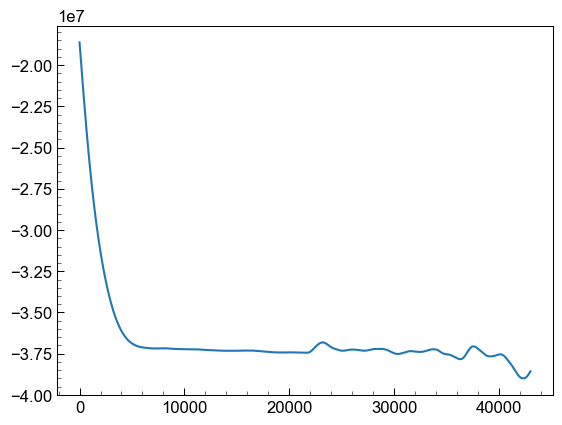

In [23]:
plt.plot(tr_Pdisp_updampled_data_forLBApick)

In [24]:
LBA_t

2.1618000000000002e-05

In [25]:
STF_tshift_k

-118

In [26]:
int(((pwin_pre+trim_margin)-LBA_t)/dt_upsampled)

-118

In [27]:
(pwin_pre+trim_margin)

2.15e-05

In [28]:
LBA_t

2.1618000000000002e-05

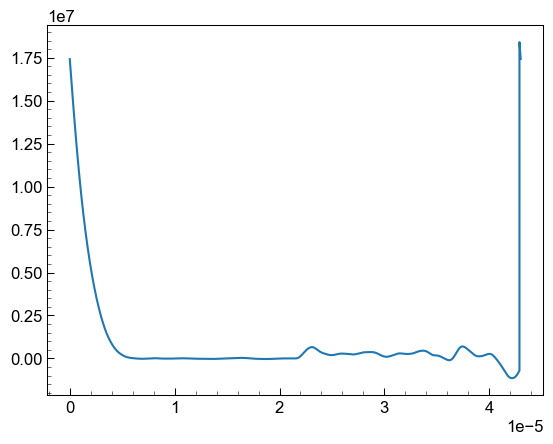

In [29]:
# plot after time shifted: the gap is caused due to the roll, which will be trimmed by the margin
plt.plot(tvec_upsampled, tr_Pdisp_upsampled_data) 

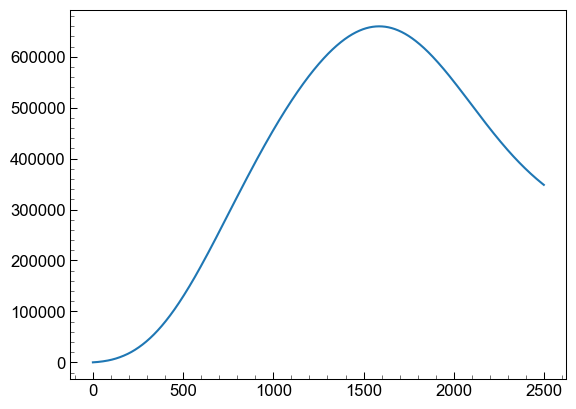

In [30]:
plt.plot(tr_Pdisp_upsampled_data[int((trim_margin+pwin_pre)/dt_upsampled):int((trim_margin+pwin_pre+peak_winlen)/dt_upsampled)])

In [31]:
np.max(tr_Pdisp_upsampled_data[int((trim_margin+pwin_pre)/dt_upsampled):int((trim_margin+pwin_pre+peak_winlen)/dt_upsampled)])

659761.8703727536

**NOTE:** Here we skipped the process of evaluating HMPW. We will evaluate the quality of the STF when fitting the STF.

# Deconvolve the attenuation factor $Q^{-1}$

$$y(\omega) = s(\omega)G(\omega; \mathbf{x})  B(\omega), $$
where

$$ B(\omega) =\exp{\left( - \dfrac{\omega t}{2 Q(\omega)} \right) } .$$

For the far-field P wave pulse is written as

$$ u^{FP}(t) = \dfrac{1}{4 \pi \rho \alpha^3} \dfrac{1}{R} A^{FP} \dot{M}_0 (t) $$

Therefore,

$$ y^{FP}(\omega) = C \dot{M}_0 (\omega) B(\omega), $$

where $C$ is a constant including radiation pattern, source distance, density and wave speed.

For the case without attenuation, the source time function can be estimated as 

$$ \dot{M}_0 (\omega) = y^{FP}(\omega)/C. $$

However, when considering the attenuation factor, we need to deconvolve it as follows:

$$ \dot{M}_0 (\omega) = y^{FP}(\omega)/\{CB(\omega)\}. $$


We next deconvolve the attenuation factor from the STF and repeat the analysis of source parameters.

The coefficient $C$ is already computed in the processing above. From this section, we compute the deconvolution with the waterlevel  

$$ \dot{M}_0 (t) = \mathcal{F}^{-1} \dfrac{y(\omega)/C}{\max \{|B(\omega)|, k|B(\omega)| \}}, $$ 

to estimate the "true" source time function and its source parameters.

In [32]:
def get_Qinv(freq, fq, Qinv):
    # interpolate the Q from the Qinv data
    cs = CubicSpline(fq, Qinv)
    
    Qinv_interp = np.zeros(len(freq))
    for i, ff in enumerate(freq):
        if ff<fq[0]:
            Qinv_interp[i] = Qinv[0] # extrapolate the minimum frequency Qinv
        elif ff>fq[-1]:
            Qinv_interp[i] = Qinv[-1] # extrapolate the maximum frequency Qinv
        else:
            Qinv_interp[i] = cs(ff)  
                
    return Qinv_interp

In [33]:
# parameters of deconvolution
Ndata_FFT = len(tvec_upsampled)
# NFFT = 2**(Ndata-1).bit_length()
NFFT = Ndata_FFT # same length of the data for the sake of simplicity
print(Ndata_FFT, NFFT)

43000 43000


In [34]:
df_Qinv_quantile.head()

,freq,Qinv_25,Qinv_50,Qinv_75
0,0.0390625,0.0110213,0.0331905,0.047364
1,0.078125,0.0095098,0.0186436,0.0360338
2,0.117188,0.00714952,0.0161767,0.0238027
3,0.15625,0.00490217,0.0109082,0.0176517
4,0.195312,0.0042456,0.00880498,0.0147662


Text(0, 0.5, 'Attenuation, $Q^{-1}$')

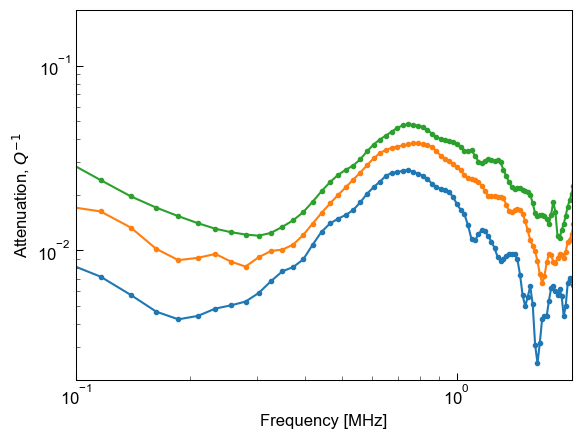

In [35]:
# test reading the Qinv
F_freq = np.fft.rfftfreq(NFFT, d=dt_upsampled)

for iq in [25, 50, 75]:
    Qinv = get_Qinv(F_freq, df_Qinv_quantile.freq.values*1e6, df_Qinv_quantile[f"Qinv_{iq}"].values).astype(complex)
    plt.loglog(F_freq/1e6, Qinv.real, ".-")
    
plt.xlim([0.1, 2])
plt.ylim([0.002, 0.2])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Attenuation, $Q^{-1}$")


Text(0, 0.5, 'Attenuation, $Q^{-1}$')

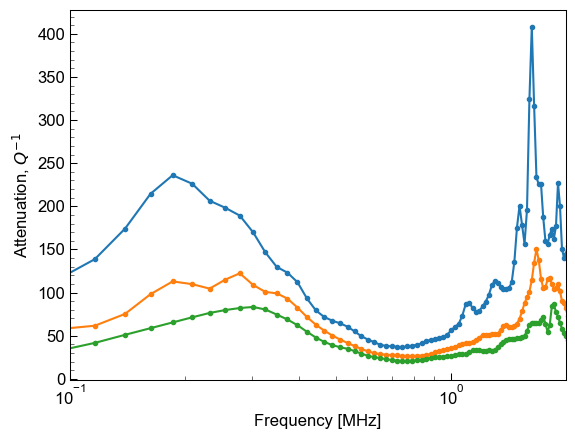

In [36]:
# test reading the Qinv
F_freq = np.fft.rfftfreq(NFFT, d=dt_upsampled)

for iq in [25, 50, 75]:
    Qinv = get_Qinv(F_freq, df_Qinv_quantile.freq.values*1e6, df_Qinv_quantile[f"Qinv_{iq}"].values).astype(complex)
    plt.semilogx(F_freq/1e6, 1/Qinv.real, ".-")
    
plt.xlim([0.1, 2])
# plt.ylim([0.002, 0.2])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Attenuation, $Q^{-1}$")


## Compute attenuation factor and deconvolve it from STF

In [37]:
fo = h5py.File(dataoutdir+f"/STF_all_{gougepatch_id}_Q{Qinv_quart}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}.hdf5", 'r+')

F_freq = np.fft.rfftfreq(NFFT, d=dt_upsampled)
vp = 6200 #[m/s]

k_waterlevel_debugplot = k_waterlevel # 0.3 #0.15  #0.3 # We searched the best value by trial and error.

# for Qinv_quart in [25, 50, 75]:
for Qinv_quart in [25, 50]:
#     Qinv_quart = 50
       
    # get interpolated Q^{-1}
    Qinv_interp = get_Qinv(F_freq, df_Qinv_quantile.freq.values*1e6, df_Qinv_quantile[f"Qinv_{Qinv_quart}"].values).astype(float)
    if f"Qinv_{Qinv_quart}" in fo[f"{datacase}"].keys():
        del fo[f"{datacase}/Qinv_{Qinv_quart}"]
        
    fo.create_dataset(f"{datacase}/Qinv_{Qinv_quart}", data=Qinv_interp.real)

    for k, datacase in enumerate(tqdm(datacases)):
    #     print(datacase)
#         fig, ax = plt.subplots(1, 1, figsize=(7, 6))
        fig, ax = plt.subplots(1, 1, figsize=(7, 6))
    
        df_trimP_coef_event = df_trimP_coef.loc[datacase] # coefficients on the event

        for i, stnm in enumerate(AEsensor_list):

        # Compute attenuation factor
            
            # debug_source_dist = df_AEevents_isocoord.loc[f"{stnm}__{datacase}", "rlen_sourcedist"] # [m]
            # Update: use the source distance for each event
            source_dist = df_trimP_coef_event[df_trimP_coef_event["OL"]==stnm]["rdist"].values[0] # [m]
            # print(source_dist)
            tt = source_dist/vp
            # print(f"{stnm} {source_dist}m,  {tt*1e6:.2f}μs")

            Bomega_interp = np.exp(-np.pi * F_freq * tt * Qinv_interp)

            # store to the hdf5
            if f"Bomega_{Qinv_quart}" in fo[f"{datacase}/{stnm}"].keys():
                del fo[f"{datacase}/{stnm}/Bomega_{Qinv_quart}"]
            fo.create_dataset(f"{datacase}/{stnm}/Bomega_{Qinv_quart}", data=Bomega_interp)
            
            # debug plot Bomega with waterlevel
            Bomega_wlv = np.maximum(np.abs(Bomega_interp), (k_waterlevel_debugplot*np.abs(Bomega_interp).max()))
            ax.plot(F_freq/1e6, Bomega_interp, ":", c=lc[i], label="")
            ax.plot(F_freq/1e6, Bomega_wlv, ".-", c=lc[i], label=stnm)
            
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend(loc=1)
        ax.set_xlim([0.06, 2])
        ax.set_ylim([0.06, 1.2])
        ax.set_xlabel("Frequency [MHz]")
        ax.set_ylabel(r"$B(\omega)$")
        
        figdir_Bomega = "../figure/03_computePdisp/Bomega_debug"
        if not os.path.exists(figdir_Bomega):
            os.makedirs(figdir_Bomega)
    

        ax.set_title(f"{gougepatch_id} {datacase} Q{Qinv_quart}")
        plt.tight_layout()
        plt.savefig(figdir_Bomega+f"/Bomega_{gougepatch_id}_{datacase}_Q{Qinv_quart}.png", format="png", dpi=80)

        plt.close()
        plt.clf()
        
fo.close()

100%|███████████████████████████████████████████| 44/44 [00:06<00:00,  6.78it/s]


<Figure size 640x480 with 0 Axes>

# Re-analyze the source time function with the deconvolution

We repeat the processes as the `noQcorr` with the deconvolution of attenuation factor. We deconvolve it from the velocity waveform with the margin so that we can detrend  the effect of deconvolution as well as trim the edge effect of the deconvolution.

### process flow

1. load velocity pulse with trim margin
2. correct the polarity
3. scale from uz to M0
4. upsampling
5. deconvolve attenuation factor and **apply tapering before detrend to remove edge effect**
6. integrate to convert from velocity to displacement
7. search left bottom amplitude **updated process**
> The threshold is that the LBA is selected from the first zero-crossing with the LBA_buffer.
> To improve the detection of LBA, the slope before the pulse arrival is evaluated as negative.
8. Shift the time at the LBA align to the pre_winlen
9. remove the offset by the value of LBA
10. trim the margin
11. store to the HDF5

### Method to search the LBA

To make the searching algorithm robust, we first compute the slope of the window before the arrival of pulse. If the slope is positive, i.e., no bump at the LBA, we subtract the slope to pick the LBA.  

In [38]:
pwin_pre, trim_margin

(2e-05, 1.5e-06)

In [39]:
Ndata_FFT, Ndata

(43000, 43000)

In [40]:
datacases[29]

'fb03-087__0088'

# Compute the displacement pulse with the deconvolution of attenuation factor

In [41]:
# k_waterlevel = 0.3 #0.3 #0.25 #0.15

# LBA_buffer_winlen = 1.0e-6 # define in the loop #1e-6 # search LBA from prewin + trimmargin + LBA_buffer_winlen with the closest LBA
LBA_thresh_zerocross_ampfactor = 0.5
LBA_slope_subtract_const = -3e10

fo = h5py.File(dataoutdir+f"/STF_all_{gougepatch_id}_Q{Qinv_quart}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}.hdf5", 'r+')

fo[f"param"].attrs["NFFT"] = NFFT
fo[f"param"].attrs["k_waterlevel"] = k_waterlevel


# low-pass filter
decon_freqmax = 1e6
butterworth_order = 3 #5 : order does not affect the result

# assign with respect to the events
# polyfit_onset_shift_Qdeconv = 1.5e-6 # shift the onset due to the acausal Q deconvolution
# polyfit_winlens_Qdeconv = copy.deepcopy(polyfit_winlens)
# polyfit_winlens_Qdeconv[1] += polyfit_onset_shift_Qdeconv

for k, datacase in enumerate(tqdm(datacases)):

#     datacase = datacases_selected[9]

    figdir_Qcorr = f"../figure/03_computePdisp/STF_Q{Qinv_quart}"
    if not os.path.exists(figdir_Qcorr):
        os.makedirs(figdir_Qcorr)

    gougeevent_id = int(datacase.split("__")[1])

    fig, ax = plt.subplots(1, 1, figsize=(10, 9))
    ax2=ax.twinx()

    STF_decon_all = np.zeros((len(AEsensor_list), Ndata))
    STF_all = np.zeros((len(AEsensor_list), Ndata_nomargin))

    yshift = 0
    yshift2 = 0

    # debug plot for detrending
    figdir_detrend = f"../figure/03_computePdisp/debug_detrend_Q{Qinv_quart}"
    if not os.path.exists(figdir_detrend):
        os.makedirs(figdir_detrend)
    fig_det, ax_det = plt.subplots(1, 1, figsize=(8, 5))

    df_trimP_coef_event = df_trimP_coef.loc[datacase] # coefficients on the event

    LBA_slope_subtract = copy.deepcopy(LBA_slope_subtract_const)
    # M0_noQcorr = fo[f"{datacase}/tmp_noQcorr"].attrs["M0_fromintegral"]
    M0_bestfit = df_bestparam.loc[datacase, :].M0_best
    # if np.isnan(M0_noQcorr) | (M0_noQcorr<0.02):
    if np.isnan(M0_bestfit) | (M0_bestfit<0.03):
        # debug_plot_scalefactor = 8
        LBA_slope_subtract *= 0.1 # decrease the additional negative slope to detect LBA
    # else:
    #     debug_plot_scalefactor = 1
    
    for i, stnm in enumerate(AEsensor_list):

        tr_Pvel = select_trace(st_repeat_Pvel, stnm, datacase) # re-read P velocity waveform
        caseindex = f"{stnm}__{datacase}"
        assert tr_Pvel.stats.dataindex==caseindex

        # correct polarity to be positive
        polarity = -1 * np.sign(tr_Pvel.stats.xi1) * np.sign(channel_loc[stnm][1])
        tr_Pvel.data *= polarity

        # convert from uz to M0
        # tr_Pvel.data *= df_k_M0uz.loc[stnm].values[0]
        # update: load from the dataframe
        k_M0uz_event = df_trimP_coef_event[df_trimP_coef_event["OL"]==stnm]["k_M0uz"].values[0]
        tr_Pvel.data *= k_M0uz_event
        
        # upsample the data
        tvec_origin = tr_Pvel.times()

        tr_Pvel_upsampled_data_raw = np.interp(tvec_upsampled, tvec_origin, tr_Pvel.data)

        # variable for debug plots
        dev_tr_Pvel_upsampled_data_withdetrend_nodeconvQ = copy.deepcopy(tr_Pvel_upsampled_data_raw) # copy the original velocity waveform
        dev_tr_Pdisp_upsampled_data_nodetrend_nodeconvQ = integrate.cumulative_trapezoid(tr_Pvel_upsampled_data_raw, dx=dt_upsampled, initial=0)

        #-----------------------------------#
        #---Deconvolve attenuation factor---#
        #-----------------------------------#
        ## Update: Apply low-pass before the deconvolution
        # sos_beforedecon = signal.butter(butterworth_order, decon_freqmax, 'lowpass', fs=(1/dt_upsampled), output='sos')
        b_beforedecon, a_beforedecon = signal.butter(butterworth_order, decon_freqmax, 'lowpass', fs=(1/dt_upsampled), output='ba')

        # UPDATE: two-way filtering to better retrieve the STF
        # tr_Pvel_upsampled_data_raw_lowpass = signal.sosfiltfilt(sos_beforedecon, tr_Pvel_upsampled_data_raw)
        tr_Pvel_upsampled_data_raw_lowpass = signal.filtfilt(b_beforedecon, a_beforedecon, tr_Pvel_upsampled_data_raw, method='gust')

        Bomega_interp = fo[f"{datacase}/{stnm}/Bomega_{Qinv_quart}"]
        # F_obs = np.fft.rfft(tr_Pvel_upsampled_data_raw, n=NFFT)
        F_obs = np.fft.rfft(tr_Pvel_upsampled_data_raw_lowpass, n=NFFT)
        Bomega_wlv = np.maximum(np.abs(Bomega_interp), (k_waterlevel*np.abs(Bomega_interp).max()))
        y_obs_Qremoved = np.fft.irfft(F_obs/Bomega_wlv).real # divide the spectra by the attenuation factor
        tr_Pvel_upsampled_data = y_obs_Qremoved # velocity waveform after deconvolution of attenuation
        
        # Apply tukey taper with 10% of edge, which will be trimmed as margin, but it is required to detrend the waveform
        tukeywin = signal.windows.tukey(len(tr_Pvel_upsampled_data), alpha=0.1, sym=True)
        tr_Pvel_upsampled_data *= tukeywin
        #-----------------------------------#
        dev_tr_Pvel_upsampled_data_nodetrend_withdeconvQ = copy.deepcopy(tr_Pvel_upsampled_data)
       
        # if stnm=="OL08":
            # tr_debug = copy.deepcopy(tr_Pvel_upsampled_data)

         #-------------------------------------------#
        # Denoise the long-period noise
        #-------------------------------------------#
        dev_tr_Pvel_upsampled_data_beforedenoise = copy.deepcopy(tr_Pvel_upsampled_data)

        if denoise_method.lower()=="highpass":
            b, a = signal.butter(butterworth_order, freqmin, 'highpass', fs=(1/dt_upsampled), output='ba')
            # apply tapering
            win = signal.windows.tukey(len(tr_Pvel_upsampled_data), 0.05)
            tr_Pvel_upsampled_data *= win
            tr_Pvel_upsampled_data= signal.filtfilt(b, a, tr_Pvel_upsampled_data, method='gust') # using Gustafsson’s method

        
        elif denoise_method.lower()=="detrend":
            # print(datacase, stnm)
            # store for detrending
            detrend_eventdata["k_M0uz_event"] = k_M0uz_event
            detrend_eventdata["source_dist"] = df_trimP_coef_event[df_trimP_coef_event["OL"]==stnm]["rdist"].values[0] # [m]
            detrend_eventdata["datacase"] = datacase
            detrend_eventdata["stnm"] = stnm
            detrend_eventdata["P_onset"] = onset
            
            figdir_debug = f"../figure/03_computePdisp/Denoise_Q{Qinv_quart}/{denoise_method.lower()}/{stnm}/"
            if not os.path.exists(figdir_debug):
                os.makedirs(figdir_debug)
            detrend_eventdata["figname"] = figdir_debug+f"debug_{datacase}_{stnm}_Q{Qinv_quart}_detrend.png"

            # set the onset time shift
            if (gougeevent_id, stnm) in [(30, "OL22"),  (44, "OL22"), (50, "OL22"), (110, "OL22")]:
                # correct the onset shift
                polyfit_onset_shift_Qdeconv = 0.5e-6

            elif (gougeevent_id, stnm) in [(88, "OL22")]:
                polyfit_onset_shift_Qdeconv = 0.25e-6
                
            else:
                polyfit_onset_shift_Qdeconv = 1.5e-6

            polyfit_winlens_Qdeconv = copy.deepcopy(polyfit_winlens)
            polyfit_winlens_Qdeconv[1] += polyfit_onset_shift_Qdeconv
   
            tr_Pvel_upsampled_data = STF_multiwindow_detrend(tvec_upsampled, tr_Pvel_upsampled_data, onset-polyfit_onset_shift_Qdeconv, polyfit_winlens_Qdeconv, 
                            polyfit_Rcontinu_buffer, polyfit_smooth_lowpass_freqmax, polyords=polyords, debugplot=True, eventdata=detrend_eventdata)

            plt.clf()
            plt.close()

        #------------------------#
        #---Detrending the velocity waveform---#
        #------------------------#

        # # detrend the velocity waveform
        # # if (gougeevent_id==49) & (stnm=="OL08"):
        # #     # the S/N is low so that consider the trim margin for detrending
        # #     detrend_stind = 0 # UPDATE 2024.11.5: include the margin for the detrend window 
        # #     detrend_etind = len(tr_Pvel_upsampled_data)
        # # else:
        # # UPDATE: remove constant offset
        # detrend_stind = int((trim_margin+pwin_pre-detrend_pwin_pre)/dt_upsampled)
        # # detrend_etind = int((trim_margin+pwin_pre+detrend_pwin_len)/dt_upsampled)
        # detrend_etind = int((trim_margin+pwin_pre-detrend_pwin_len)/dt_upsampled)
        
        # k_poly = np.polynomial.polynomial.polyfit(tvec_upsampled[detrend_stind:detrend_etind], tr_Pvel_upsampled_data[detrend_stind:detrend_etind], 0) #2
        # tr_vel_poly = np.polynomial.polynomial.polyval(tvec_upsampled, k_poly)
        # tr_Pvel_upsampled_data -= tr_vel_poly        

        # # detrend the no deconv Q with the same trend for the sake of simplicity
        # dev_tr_Pvel_upsampled_data_withdetrend_nodeconvQ -= tr_vel_poly  

        # # if stnm=="OL08":
        # #     tr_debug2 = copy.deepcopy(tr_Pvel_upsampled_data)
        # #     tr_debugp = copy.deepcopy(tr_vel_poly)
            
        #--- debug plot---#
        ax_det.plot(tvec_upsampled*1e6, dev_tr_Pvel_upsampled_data_nodetrend_withdeconvQ/k_M0uz_event*1e3, "--", c=lc[i], label="")
        ax_det.plot(tvec_upsampled*1e6, tr_Pvel_upsampled_data/k_M0uz_event*1e3, "-", c=lc[i], label=f"{stnm}")
        # ax_det.plot(tvec_upsampled*1e6, tr_vel_poly/k_M0uz_event*1e3, ":", c=lc[i], label="", lw=1)
        ax_det.plot(tvec_upsampled*1e6, tukeywin*M0_bestfit, "-", lw=0.75, c="gray") # scale with M0 for the visuallization
        #------------------------#
        #---Integrate velocity to convert from the velocity to the displacement---#
        #------------------------#
        tr_Pdisp_upsampled_data = integrate.cumulative_trapezoid(tr_Pvel_upsampled_data, dx=dt_upsampled, initial=0)

        #------------------------#
        #---Search left bottom amplitude (LBA)---#
        #------------------------#
        # 1. compute the slope before the pick
        slope_st = int((pwin_pre+trim_margin-2e-6)/dt_upsampled)
        slope_et = int((pwin_pre+trim_margin)/dt_upsampled)
        LBA_slope_k_poly = np.polynomial.polynomial.polyfit(tvec_upsampled[slope_st:slope_et], tr_Pdisp_upsampled_data[slope_st:slope_et], 1)
#         print(LBA_slope_k_poly)

        tr_Pdisp_updampled_data_forLBApick = copy.deepcopy(tr_Pdisp_upsampled_data) # this is used to pick the LBA

        if LBA_slope_k_poly[1]>=0:
#             print(LBA_slope_k_poly[1])
            LBA_slope_k_poly[1] -= LBA_slope_subtract # added extra slope to make STF_slope negative after subtraction
            tr_Pdisp_updampled_data_forLBApick -= np.polynomial.polynomial.polyval(tvec_upsampled, LBA_slope_k_poly) # subtract slope to detect LBA

        # pick the LBA as it is
        STF_grad = np.gradient(tr_Pdisp_updampled_data_forLBApick)

        # https://stackoverflow.com/a/3843124
        zero_crossings = np.where(np.diff(np.sign(STF_grad)) > 0)[0]

        #         min_list = zero_crossings
        min_list = []

        # remove if the amplitude of peak is greater than the threshold
        for zeroid in zero_crossings:
            # print(tr_Pdisp_updampled_data_forLBApick[zeroid] , LBA_thresh_zerocross_ampfactor * np.max(tr_Pdisp_updampled_data_forLBApick))
            # if tr_Pdisp_updampled_data_forLBApick[zeroid] < LBA_thresh_zerocross_ampfactor * np.max(tr_Pdisp_updampled_data_forLBApick):
            min_list.append(zeroid)

        min_list = np.array(min_list)

        # update: except buffer the ID50 OL 08: This is needed
        if (gougeevent_id == 50) & (stnm=="OL08"):
            LBA_buffer_winlen = 1.2e-6 # Use longer buffer on the event
        else:
            LBA_buffer_winlen = 1.0e-6 # standard value for the LBA buffer
            
        try:
            LBA_ind = min_list[np.where(int((pwin_pre+trim_margin+LBA_buffer_winlen)/dt_upsampled) - min_list > 0)[0][-1]] # search the first bump of STF; 1.2us as buffer of search window
        except:
            LBA_ind = int(np.round((pwin_pre+trim_margin)/dt_upsampled)) #use original tpick #0
            
        LBA_amp = tr_Pdisp_upsampled_data[LBA_ind]
        LBA_t = tvec_upsampled[LBA_ind]
        
        # print(min_list, LBA_t)

        #------------------------#
        #---Time shift STF---#
        #------------------------#
        STF_tshift_k = int(((pwin_pre+trim_margin)-LBA_t)/dt_upsampled) # time shift with LBA location
        # print(STF_tshift_k)
        valid_flag_timeshift = 1
        # if np.abs(STF_tshift_k)>int(detrend_pwin_pre/dt_upsampled):
        if np.abs(STF_tshift_k)>int(trim_margin/dt_upsampled):
            print(f"{datacase} {stnm} time shift too large.")
            # time shift is too large; set time shift as the original tpick
            LBA_ind = int(np.round((pwin_pre+trim_margin)/dt_upsampled)) #use original tpick #0
            LBA_amp = tr_Pdisp_upsampled_data[LBA_ind]
            LBA_t = tvec_upsampled[LBA_ind]
            STF_tshift_k = int(((pwin_pre+trim_margin)-LBA_t)/dt_upsampled) # time shift with LBA location
            valid_flag_timeshift = 0

        
        tr_Pvel_upsampled_data= np.roll(tr_Pvel_upsampled_data, STF_tshift_k)
        dev_tr_Pvel_upsampled_data_withdetrend_nodeconvQ = np.roll(dev_tr_Pvel_upsampled_data_withdetrend_nodeconvQ, STF_tshift_k)
        tr_Pdisp_upsampled_data = np.roll(tr_Pdisp_upsampled_data, STF_tshift_k)
        dev_tr_Pdisp_upsampled_data_nodetrend_nodeconvQ = np.roll(dev_tr_Pdisp_upsampled_data_nodetrend_nodeconvQ, STF_tshift_k)
        tr_Pdisp_updampled_data_forLBApick = np.roll(tr_Pdisp_updampled_data_forLBApick, STF_tshift_k)
        # tr_vel_poly = np.roll(tr_vel_poly, STF_tshift_k)
        
        #------------------------#
        #---Remove the offset---#
        #------------------------#
        # offset_ind = np.where((STF_center-STF_offset_init_t-STF_offset_winlen < tvec_upsampled) & (tvec_upsampled < STF_center-STF_offset_init_t))[0]
        # we use the amplitude of LBA as the offset for the simplicity
        tr_Pdisp_upsampled_data -= LBA_amp

        # trim the margin to remove the effect of the roll
        # The edge effect due to the deconvolution can be mitigated by trimming of the margins
        tr_Pvel_upsampled_data_margintrimmed = tr_Pvel_upsampled_data[trim_margin_k:-trim_margin_k]
        dev_tr_Pvel_upsampled_data_withdetrend_nodeconvQ_margintrimmed = dev_tr_Pvel_upsampled_data_withdetrend_nodeconvQ[trim_margin_k:-trim_margin_k]
        tr_Pdisp_upsampled_data_margintrimmed = tr_Pdisp_upsampled_data[trim_margin_k:-trim_margin_k]
        dev_tr_Pdisp_upsampled_data_nodetrend_nodeconvQ_margintrimmed = dev_tr_Pdisp_upsampled_data_nodetrend_nodeconvQ[trim_margin_k:-trim_margin_k]
        tr_Pdisp_updampled_data_forLBApick_margintrimmed = tr_Pdisp_updampled_data_forLBApick[trim_margin_k:-trim_margin_k]
        # tr_vel_poly_margintrimmed = tr_vel_poly[trim_margin_k:-trim_margin_k]

        # store to HDF5
        if f"Q{Qinv_quart}" in fo[f"{datacase}/{stnm}/"].keys():
            del fo[f"{datacase}/{stnm}/Q{Qinv_quart}/M0dot"]
            del fo[f"{datacase}/{stnm}/Q{Qinv_quart}"]

        fo.create_dataset(f"{datacase}/{stnm}/Q{Qinv_quart}/M0dot", data=tr_Pdisp_upsampled_data_margintrimmed)
        LBA_ind_shifted = LBA_ind + STF_tshift_k - int(trim_margin_k)
        LBA_amp_shifted = tr_Pdisp_upsampled_data_margintrimmed[LBA_ind_shifted]
        LBA_t_shifted = pwin_pre
#         print(LBA_ind_shifted, LBA_amp_shifted, LBA_t_shifted)
        
        fo[f"{datacase}/{stnm}/Q{Qinv_quart}"].attrs["LBA_ind"] = LBA_ind_shifted # one gridpoint varies due to the rounding of time shift
        fo[f"{datacase}/{stnm}/Q{Qinv_quart}"].attrs["LBA_amp"] = LBA_amp_shifted
        fo[f"{datacase}/{stnm}/Q{Qinv_quart}"].attrs["LBA_t"] = LBA_t_shifted
        fo[f"{datacase}/{stnm}/Q{Qinv_quart}"].attrs["valid_flag_timeshift"] = valid_flag_timeshift # store the time shift valid flag

        #------------------------#
        #---Compute noise level---#
        #------------------------#
        # compute RMSE of noise
        st_noise = np.max([0, LBA_ind_shifted-int(noise_winlen/dt_upsampled)])
        et_noise = LBA_ind_shifted
        noise_rmse = np.sqrt(np.mean((tr_Pdisp_upsampled_data_margintrimmed[st_noise:et_noise]**2))) # evaluate noise RMSE
        noise_std = np.std(tr_Pdisp_upsampled_data_margintrimmed[st_noise:et_noise]) # evaluate noise STD
        noise_peak = np.max(np.abs(tr_Pdisp_upsampled_data_margintrimmed[st_noise:et_noise])) 
        
        # compute peak P amp
        st_pmax = LBA_ind_shifted
        et_pmax = LBA_ind_shifted + int(peak_winlen/dt_upsampled)
        pmax = np.max(tr_Pdisp_upsampled_data_margintrimmed[st_pmax:et_pmax])
        
        # SNR_sensor = pmax/noise_rmse
        SNR_sensor = pmax/noise_std
        # SNR_sensor = pmax/noise_peak
        
        # print(noise_rmse, pmax, SNR_sensor)
        fo[f"{datacase}/{stnm}/Q{Qinv_quart}"].attrs["noise_rmse"] = noise_rmse
        fo[f"{datacase}/{stnm}/Q{Qinv_quart}"].attrs["noise_peak"] = noise_peak
        fo[f"{datacase}/{stnm}/Q{Qinv_quart}"].attrs["pmax"] = pmax
        fo[f"{datacase}/{stnm}/Q{Qinv_quart}"].attrs["SNR_sensor"] = SNR_sensor
        
        STF_all[i, :] = tr_Pdisp_upsampled_data_margintrimmed

        # valid_flag_noiselevel = fo[f"{datacase}/{stnm}/noQcorr"].attrs["valid_flag_noiselevel"]
        # valid_flag_Rzerocross = fo[f"{datacase}/{stnm}/noQcorr"].attrs["valid_flag_Rzerocross"]

        # if not valid_flag_timeshift: # check if the LBA is not found
            # plotls = "--"
        # elif valid_flag_noiselevel: # we allow for the threshold of valid_flag_Rzerocross in this plot
            # plotls = "-"
        # else:
            # plotls = "--"

        plotls = "-"

        if i==0:
            displabel1="disp no deconvQ no detrend"
        else:
            displabel1=None

        plotampnorm1 = np.max(tr_Pdisp_upsampled_data_margintrimmed)
        # ax.plot((tvec_upsampled_margintrimmed-trim_margin)*1e6, yshift + tr_Pdisp_upsampled_data_margintrimmed/1e6, ls=plotls, c=lc[i], label=f"{stnm}", lw=2)
        ax.plot((tvec_upsampled_margintrimmed-trim_margin)*1e6, yshift + tr_Pdisp_upsampled_data_margintrimmed/plotampnorm1, ls=plotls, c=lc[i], label=f"{stnm}", lw=2)
        # ax.plot((tvec_upsampled_margintrimmed-trim_margin)*1e6, yshift + tr_Pdisp_updampled_data_forLBApick_margintrimmed/1e6, ls=":", c="gray", label="", lw=1) # debug for detrend of slope
        ax.plot((tvec_upsampled_margintrimmed-trim_margin)*1e6, yshift + tr_Pdisp_updampled_data_forLBApick_margintrimmed/plotampnorm1, ls=":", c="gray", label="", lw=1) # debug for detrend of slope

        # plot the displacement waveform without deconvQ and detrend below.
        ax.plot((tvec_upsampled_margintrimmed-trim_margin)*1e6, yshift + dev_tr_Pdisp_upsampled_data_nodetrend_nodeconvQ_margintrimmed/plotampnorm1, ls=":", c="b", label=displabel1, lw=1) # debug for detrend of slope
        
        ax.plot((pwin_pre)*1e6, yshift + 0/1e6, marker="v", c="k", label=f"") # time shifted with LBA
        # ax.plot((LBA_t-trim_margin)*1e6, yshift + 0/1e6, marker="v", c="k", label=f"")

        ax.text(0, yshift+0.1, f"{noise_rmse:.1g}, SNR={SNR_sensor:.2f}")
        
        yshift -= 1 #0.8/debug_plot_scalefactor #0.1 #0.8

        # if i==len(AEsensor_list)-1:
        #     st_offset = tvec_upsampled[offset_ind[0]]
        #     et_offset = tvec_upsampled[offset_ind[-1]]
        #     ax.plot((np.array([st_offset, et_offset])-trim_margin)*1e6, -0.1*np.ones(2), "-", marker="", c="k", label=None, lw=0.75)

        # plot velocity waveform as twin axis
        if i==0:
            vellabel1="vel. before Qcorr"
            vellabel2="vel. after Qcorr"
        else:
            vellabel1=None
            vellabel2=None

        # plot velocity before and after the deconvolution
        plotampnorm2 = np.max(dev_tr_Pvel_upsampled_data_withdetrend_nodeconvQ_margintrimmed)
        plotampnorm2_factor = 4
        # ax2.plot((tvec_upsampled_margintrimmed-trim_margin)*1e6, yshift2 + dev_tr_Pvel_upsampled_data_withdetrend_nodeconvQ_margintrimmed/k_M0uz_event*1e3, "-", c=lc[i], label=vellabel1, lw=1)
        ax2.plot((tvec_upsampled_margintrimmed-trim_margin)*1e6, yshift2 + dev_tr_Pvel_upsampled_data_withdetrend_nodeconvQ_margintrimmed/plotampnorm2/plotampnorm2_factor, "-", c=lc[i], label=vellabel1, lw=1)
        # ax2.plot((tvec_upsampled_margintrimmed-trim_margin)*1e6, yshift2 + tr_Pvel_upsampled_data_margintrimmed/k_M0uz_event*1e3, "-.", c=lc[i], label=vellabel2, lw=1)
        ax2.plot((tvec_upsampled_margintrimmed-trim_margin)*1e6, yshift2 + tr_Pvel_upsampled_data_margintrimmed/plotampnorm2/plotampnorm2_factor, "-.", c=lc[i], label=vellabel2, lw=1)
        # ax2.plot((tvec_upsampled_margintrimmed-trim_margin)*1e6, yshift2 + tr_vel_poly_margintrimmed/k_M0uz_event*1e3, "-", c=lc[i], label=None, lw=0.75)        
        # ax2.plot((tvec_upsampled_margintrimmed-trim_margin)*1e6, yshift2 + tr_vel_poly_margintrimmed/plotampnorm2/plotampnorm2_factor, "-", c=lc[i], label=None, lw=0.75)        
        ax2.set_ylabel('Velocity [mm/s]')
        yshift2 -= 1 #2/debug_plot_scalefactor #0.25 #2 


    
    # ax.axvspan(0, STF_removal_tp*1e6, facecolor='gray', alpha=0.1)
    # ax.axvspan((STF_removal_tp+STF_removal_winlen)*1e6, (pwin_pre+pwin_len)*1e6, facecolor='gray', alpha=0.1)

    ax.axvspan(0, pwin_pre*1e6, facecolor='gray', alpha=0.1)
    ax.axvspan((pwin_pre+polyfit_winlens[1])*1e6, (pwin_pre+pwin_len)*1e6, facecolor='gray', alpha=0.1)


    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2, bbox_to_anchor=(1.05, 1.0))

    ax.set_xlabel("Time [μs]")
    ylabelstr = r"$\dot{M}_0(t)$"
    ax.set_ylabel(r"{} [MNm/s]".format(ylabelstr)) # The unit is in MNm/s

    #     ax.set_xlim([0, 9])
    ax.set_ylim([-6, 2])
    ax2.set_ylim([-6, 2])

    fig_det # debug velocity plot for detrend
    ax_det.set_xlabel("Time [μs]")
    ax_det.set_ylabel(r"Velocity [mm/s]")
    ax_det.set_title(f"{gougepatch_id} {datacase} Q{Qinv_quart} M0prelim={M0_bestfit:.2g} Nm")
    ax_det.legend(loc=1)
    plt.tight_layout()
    plt.savefig(figdir_detrend+f"/debug_detrend_{gougepatch_id}_{datacase}_Q{Qinv_quart}.png", format="png", dpi=80)
    plt.clf()
    plt.close()   
    
    fig
    ax.set_title(f"{gougepatch_id} {datacase} Q{Qinv_quart} M0prelim={M0_bestfit:.2g} Nm")
    ax.set_title(f"{gougepatch_id} {datacase} Q{Qinv_quart} M0prelim={M0_bestfit:.2g} Nm")
    ax.legend(loc=1)
    plt.savefig(figdir_Qcorr+f"/STF_{gougepatch_id}_{datacase}_Q{Qinv_quart}.png", format="png", dpi=80)
   
    plt.clf()
    plt.close()   



fo.close()

 61%|██████████████████████████▍                | 27/44 [00:47<00:29,  1.71s/it]

tdiff of Rcontinu is larger than polyfit_Rcontinu_buffer: set the Rcontinu at the polyfit_Rcontinu_buffer.


100%|███████████████████████████████████████████| 44/44 [01:16<00:00,  1.75s/it]


In [42]:
tvec_upsampled[zero_crossings]*1e6

array([ 5.425,  7.099,  9.097, 11.915, 13.702, 15.064, 17.989, 20.359,
       21.896, 25.109, 26.944, 28.342, 30.311, 32.544, 34.782, 36.422,
       38.844])

In [43]:
datacases[16]

'fb03-087__0050'

In [44]:
tr_Pdisp_updampled_data_forLBApick[zeroid] < LBA_thresh_zerocross_ampfactor * np.max(tr_Pdisp_updampled_data_forLBApick)


True

In [45]:
LBA_thresh_zerocross_ampfactor * np.max(tr_Pdisp_updampled_data_forLBApick)

0.0

In [46]:
tr_Pdisp_updampled_data_forLBApick[zeroid]

-6699179.858241606

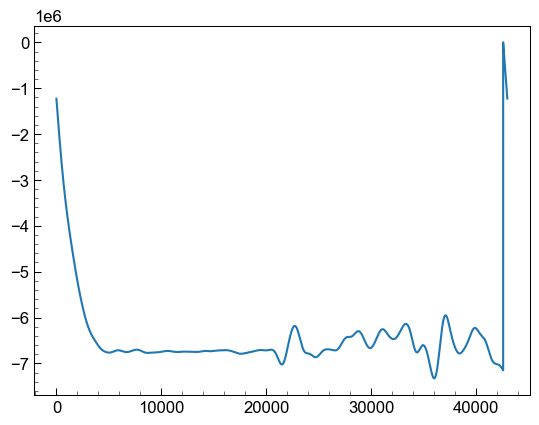

In [47]:
plt.plot(tr_Pdisp_updampled_data_forLBApick)

In [48]:
pwin_pre+pwin_len

4e-05

In [49]:
df_trimP_coef_event

,rdist,incidentangle,dip,azimuth,k_M0uz,TR,beta_coef_p,OL
datacase,,,,,,,,
fb03-087__0131,0.0957288,58.5127,43.0102,-49.9697,1.2959e+15,2.7e-06,0.565246,OL23
fb03-087__0131,0.119537,65.2738,54.155,148.935,1.50727e+15,2.7e-06,0.51802,OL07
fb03-087__0131,0.187854,74.5638,68.1221,16.6678,3.81809e+15,2.7e-06,0.470379,OL08
fb03-087__0131,0.225087,77.1654,71.881,-166.483,5.8113e+15,2.7e-06,0.460867,OL22


In [50]:
M0_bestfit

0.66

In [51]:
np.tan(np.deg2rad(0.02)) * 4

0.0013962634583056205

# Conclusion

We computed the P wave displacement pulse from the velocity wave form after pre-processing.
We fit the synthetic STF to evaluate the moment-duration parameters.